# Ch7. 유동성 모델링

- 유동성 위험의 원인: 완전 시장과 대칭적 정보 패러다임으로부터의 이탈 -> 도덕적 해이와 역선택으로 이어질 수 있음
- 유동성을 고려한 모델: 유동성이 요구되는 자산 수익과 불확실성 수준 모두에 영향을 미침 ~ more applicable
- 유동성: 채무불이행 가능성 추정에 있어 상당히 중요함
- 유동성 자산: 상당한 가격 영향 없이 대량의 자산이 판매될 수 있는 상태 ~ 거래 비용이라고도 함

(\*) 유동성을 정의하는 네 가지 특성
- 집중도: 자산을 같은 가격에 동시에 거래할 수 있는 능력 ~ 거래 비용 높으면 매수와 매도 가격의 차이 큼
- 즉시성: 대량의 매수 or 매도 주문을 거래할 수 있는 속도
- 깊이: 다양한 가격으로 풍부한 주문을 처리할 수 있는 많은 수의 구매자와 판매자가 존재하는지
- 탄력성: 불균형에서 회복하는 시장의 능력 ~ 주문 불균형이 빠르게 해소되는 가격 회복 과정

- 군집화 분석 -> 유동성 측정 군집화 -> 투자자가 유동성의 어느 부분에 집중해야 하는지 이해
- 군집화 분석: by 가우스 혼합 모델(GMM), 가우스 혼합 코풀라 모델(GMCM)
- GMM: 타원 분포에 잘 작동
- GMCM: 상관관계 고려 ~ GMM의 확장

(\*) 유동성 척도: 거래량 / 거래 비용 / 가격 영향 / 시장 영향

1. 거래량 기반 유동성 척도
- 시장이 깊을 때, 즉 금융 시장이 풍부한 주문을 충족할 수 있는 능력이 있을 때 대규모 주문이 처리됨
- 시장에 깊이가 없으면, 주문 불균형과 불연속성이 나타남

(i) 유동성 비율: 1%의 가격 변동을 유발하는 데 필요한 거래량의 정도 측정
$\\ LR_{it}=\frac{\sum^T_{t=1}P_{it}V_{it}}{\sum^T_{t=1}|PC_{it}}$
- $P_{it}$: t일의 주식 i의 총 가격
- $V_{it}$: t일의 주식 i의 거래량
- $|PC_{it}|$: t일과 t-1 에서의 가격 차이의 절댓값
- 비율이 높을수록 자산 i의 유동성이 높아짐 ~ 높은 거래량 / 낮은 가격차

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(10,6)
pd.set_option('use_inf_as_na', True)

In [2]:
liq_data=pd.read_csv('bid_ask.csv')
liq_data.head()

,Unnamed: 0,Date,EXCHCD,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,OPENPRC,vwretx
0,1031570,2019-01-02,3.0,INTC,INTEL CORP,45.77,47.470,47.08,18761673.0,0.003196,4564000.0,45.960,0.001783
1,1031571,2019-01-03,3.0,INTC,INTEL CORP,44.39,46.280,44.49,32254097.0,-0.055013,4564000.0,46.150,-0.021219
2,1031572,2019-01-04,3.0,INTC,INTEL CORP,45.54,47.570,47.22,35419836.0,0.061362,4564000.0,45.835,0.033399
3,1031573,2019-01-07,3.0,INTC,INTEL CORP,46.75,47.995,47.44,22724997.0,0.004659,4564000.0,47.100,0.009191
4,1031574,2019-01-08,3.0,INTC,INTEL CORP,46.78,48.030,47.74,22721240.0,0.006324,4564000.0,47.800,0.010240


In [3]:
# 롤링 윈도우
rolling_five=[]
for j in liq_data.TICKER.unique():
    for i in range(len(liq_data[liq_data.TICKER==j])):
        rolling_five.append(liq_data[i:i+5].agg({'BIDLO':'min', 'ASKHI':'max','VOL':'sum',
                                                 'SHROUT':'mean','PRC':'mean'})) # function to use for aggregating data
rolling_five_df=pd.DataFrame(rolling_five)
rolling_five_df.columns=['bidlo_min','askhi_max','vol_sum','shrout_mean','prc_mean']
liq_vol_all=pd.concat([liq_data, rolling_five_df], axis=1)


In [4]:
liq_ratio=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        liq_ratio.append((liq_vol_all['PRC'][i+1:i+6]*liq_vol_all['VOL'][i+1:i+6]).sum()
                         /(np.abs(liq_vol_all['PRC'][i+1:i+6].mean()-liq_vol_all['PRC'][i:i+5].mean())))

(ii) 휘-회벨 비율
$\\ L_{HH}=\frac{P_{max}-P_{min}}{P_{min}}/V/\bar{P}\times\text{shrout}$
- $P_{max},\ P_{min}$: 각 정해진 기간 동안의 최고/최저가
- $\bar{P}$: 정해진 기간 동안의 평균 종가

In [5]:
Lhh=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        Lhh.append((liq_vol_all['PRC'][i:i+5].max()-liq_vol_all['PRC'][i:i+5].min())/
                   liq_vol_all['PRC'][i:i+5].min()/
                   (liq_vol_all['VOL'][i:i+5].sum()/liq_vol_all['SHROUT'][i:i+5].mean()*liq_vol_all['PRC'][i:i+5].mean()))

(iii) 회전율: 발행 주식 수에 대한 변동성의 비율
$LR_{it}=\frac{1}{D_{it}}\frac{\sum^T_{t=1}Vol_{it}}{\sum^T_{t=1}\text{shrout}_{it}}$
- $D_{it}$: 거래일 수 
- $Vol_{it}$: 시간 t에 거래된 주식 수
- $\text{shrout}_{it}$: 시간 t에 발행된 주식 수
- 회전율: 일일 데이터 기반 ~ 거래 빈도를 의미함

In [6]:
turnover_ratio=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        turnover_ratio.append((1/liq_vol_all['VOL'].count())*
                              (np.sum(liq_vol_all['VOL'][i:i+1])/np.sum(liq_vol_all['SHROUT'][i:i+1])))
liq_vol_all['liq_ratio']=pd.DataFrame(liq_ratio)
liq_vol_all['Lhh']=pd.DataFrame(Lhh)
liq_vol_all['turnover_ratio']=pd.DataFrame(turnover_ratio)

2. 거래 비용 기반 유동성 측정
- 거래 비용: 투자자가 거래 중에 부담해야 하는 비용 ~ 거래의 집행과 관련된 모든 비용
- 명시적 비용: 주문 처리, 세금 및 중개 수수료와 관련
- 암묵적 비용: 매수-매도 스프레드, 실행 시기 등과 같은 더 많은 잠재 비용을 포함함
- 높은 거래 비용 -> 투자자의 거래 방해 -> 시장의 구매자와 판매자 수 줄임 -> 거래 장소가 더 단편화된 시장으로 분기돼 얕은 시장 형성을 초래함
- 거래 비용 저렴 -> 시장이 더욱 중앙 집중화 됨
- 즉시성: 유동성의 다른 차원 ~ 거래 비용과 밀접한 관련
- 매수-매도 스프레드가 거래 비용 잘 분석 -> 자산을 현금으로 전환하는 용이성을 결정할 수 있는 유동성의 좋은 지표임

(\*) 명목 비율과 유효 매수-매도 스프레드
1. 명목 스프레드: 거래 완료 비용, 즉 매수-매도 스프레드의 차이 측정
$\\ = \frac{P_{ask}-P_{bid}}{P_{mid}}$
2. 유효 스프레드: 거래 가격과 중간 가격 사이의 편차 측정
$\\ \frac{2|P_t-P_{mid}|}{P_{mid}}$

In [7]:
liq_vol_all['mid_price']=(liq_vol_all.ASKHI+liq_vol_all.BIDLO)/2
liq_vol_all['percent_quoted_ba']=(liq_vol_all.ASKHI-liq_vol_all.BIDLO)/liq_vol_all.mid_price
liq_vol_all['percent_effective_ba']=2*abs(
    (liq_vol_all.PRC-liq_vol_all.mid_price)
)/liq_vol_all.mid_price

(\*) 롤의 스프레드 추정
$\\ = \sqrt{-cov(\Delta P_t,\Delta P_{t-1})}$

In [8]:
liq_vol_all['price_diff']=liq_vol_all.groupby('TICKER')['PRC'].diff()
liq_vol_all.dropna(inplace=True)
roll=[]

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        roll_cov=np.cov(liq_vol_all['price_diff'][i:i+5],liq_vol_all['price_diff'][i+1:i+6]) # 공분산 행렬 반환
        if roll_cov[0,1] < 0:
            roll.append(2*np.sqrt(-roll_cov[0,1]))
        else:
            roll.append(2*np.sqrt(np.abs(roll_cov[0,1])))

(\*) 코윈-슐츠 스프레드
- 하루의 고-저가 비율은 주식의 분산과 매수 호가 스프레드를 모두 반영함

In [9]:
gamma=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        gamma.append(
            (max(liq_vol_all['ASKHI'].iloc[i+1], liq_vol_all['ASKHI'].iloc[i])
             -min(liq_vol_all['BIDLO'].iloc[i+1], liq_vol_all['BIDLO'].iloc[i]))**2
        )
gamma_array=np.array(gamma)

In [10]:
beta=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        beta.append(
            (liq_vol_all['ASKHI'].iloc[i+1]-liq_vol_all['BIDLO'].iloc[i+1])**2 +
            (liq_vol_all['ASKHI'].iloc[i]-liq_vol_all['BIDLO'].iloc[i])**2
        )
beta_array=np.array(beta)

In [11]:
alpha=((np.sqrt(2*beta_array)-np.sqrt(beta_array))/
       (3-(2*np.sqrt(2))))-np.sqrt(gamma_array/(3-(2*np.sqrt(2))))
CS_spread=(2*(np.exp(alpha)-1))/(1+np.exp(alpha))

In [12]:
liq_vol_all=liq_vol_all.reset_index()
liq_vol_all['roll']=pd.DataFrame(roll)
liq_vol_all['CS_spread']=pd.DataFrame(CS_spread)

3. 가격 영향 기반 유동성 측정
- 회복력: 새로운 주문에 대한 시장의 반응을 나타냄
- 새로운 질서가 시장의 불균형을 바로잡음 -> 시장: 탄력적

(\*) 아미후드 비유동성
- 거래량에 대한 수익의 민감도 측정 ~ 거래량 $1 변할 때 절대 수익률의 변화
$\\ ILLIQ=\frac{1}{D_{it}}\sum^{D_{it}}_{d=1}\frac{|R_{itd}|}{V_{itd}}$
- $R_{itd}$: t월 d일의 주식 수익률
- $V_{itd}$: t월 d일의 달러 거래량
- $D_{it}$: t월 관찰 일수
- 예상 주가 수익률과 강한 양의 관계를 가짐



In [ ]:
dvol=[]
# 유동성 효과를 분석할 때 하루 치 데이터보다는 5/20/60일 등의 이동 합계를 사용하여 지속 가능한 유동성인지 판단함
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        dvol.append((liq_vol_all['PRC'][i:i+5]*liq_vol_all['VOL'][i:i+5]).sum()) # 리스트나 Pandas 슬라이싱: 범위 벗어나면 남아있는 데이터까지만 !
liq_vol_all['dvol']=pd.DataFrame(dvol)

In [14]:
amihud=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        amihud.append((1/liq_vol_all['RET'].count())*(
            np.sum(np.abs(liq_vol_all['RET'][i:i+1]))/np.sum(liq_vol_all['dvol'][i:i+1])
        ))

(\*) 가격 영향 비율 (수익률 대 회전율)
- 아미후드: 시가총액이 다른 주식 간 비교 불가 / 투자자의 보유 기간 무시
$\\ RtoTR=\frac{1}{D_{it}}\sum^{D_{it}}_{d=1}\frac{|R_{itd}|}{TR_{itd}}$
- $TR_{itd}$: t월 d일의 재고 i의 통화량
- 거래 빈도를 파악하기 위한 회전율 포함 -> 크기 편향이 없음

In [15]:
florackis=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        florackis.append((1/liq_vol_all['RET'].count())*
                         (np.sum(np.abs(liq_vol_all['RET'][i:i+1])/liq_vol_all['turnover_ratio'][i:i+1])))

(\*) 거래의 탄력성 계수
- 단위 시간 당 거래 수 및 주문과 같은 시간 관련 유동성 측정의 단점 보안 위한 유동성 측정
- 시장의 즉각성이 유동성 수준에 미치는 영향 평가
- 가격이 거래량에 반응하는 경우(: 탄력적), 더 큰 수준의 시장 즉각성 의미
$CET=\frac{\%\Delta V}{\%\Delta P}$
- $\%\Delta V$: 거래량의 변화
- $\%\Delta P$: 가격의 변화

In [16]:
# 차이의 백분율 계산
liq_vol_all['vol_diff_pct']=liq_vol_all.groupby('TICKER')['VOL'].diff().pct_change()
liq_vol_all['price_diff_pct']=liq_vol_all.groupby('TICKER')['PRC'].diff().pct_change()

In [17]:
cet=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        cet.append(np.sum(liq_vol_all['vol_diff_pct'][i:i+1])/np.sum(liq_vol_all['vol_diff_pct'][i:i+1]))

In [18]:
liq_vol_all['amihud']=pd.DataFrame(amihud)
liq_vol_all['florackis']=pd.DataFrame(florackis)
liq_vol_all['cet']=pd.DataFrame(cet)

4. 시장 영향 기반 유동성 측정
- 시장 내 가격 급등: 개별 주식에서 발생하는 것과 동일한 정보 제공 x
- 가격 움직임을 적절하게 포착하는 방식으로 새로운 정보 소스 식별해야 함
- CAPM의 기울기 계수: 체계적 위험, 비체계적 위험은 시장 위험이 제거되는 한 개별 주식에 귀속됨
$\\ R_i=\alpha+\beta R_m+u_i$
- $R_i$: 주식의 일 수익률
- $u_i$: 특이 or 비체계적 위험
$\\ u_i^2=\gamma_1+\gamma_2V_i+e_i$
- $V_i$: 거래량의 일 백분율 변화
- $\gamma_2$가 작을수록 가격 움직임이 작아져 유동성 수준이 높아짐

In [19]:
import statsmodels.api as sm
liq_vol_all['VOL_pct_change']=liq_vol_all.groupby('TICKER')['VOL'].pct_change()
liq_vol_all.dropna(subset=['VOL_pct_change'], inplace=True)
liq_vol_all=liq_vol_all.reset_index()

In [20]:
unsys_resid=[]
for i in liq_vol_all.TICKER.unique():
    X1=liq_vol_all[liq_vol_all['TICKER']==i]['vwretx']
    y=liq_vol_all[liq_vol_all['TICKER']==i]['RET']
    ols=sm.OLS(y, X1).fit()
    unsys_resid.append(ols.resid)

In [45]:
market_impact={}
for i, j in zip(liq_vol_all.TICKER.unique(),
                range(len(liq_vol_all['TICKER'].unique()))):
    X2=liq_vol_all[liq_vol_all['TICKER']==i]['VOL_pct_change']
    ols=sm.OLS(unsys_resid[j]**2,X2).fit()
    print('****'*30)
    print(f'OLS Result for {i}')
    print(ols.summary())
    # X2의 인덱스를 그대로 가짐
    market_impact[j]=list(ols.resid)

************************************************************************************************************************
OLS Result for INTC
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.157
Model:                            OLS   Adj. R-squared (uncentered):              0.154
Method:                 Least Squares   F-statistic:                              46.31
Date:                    화, 27 1 2026   Prob (F-statistic):                    7.53e-11
Time:                        13:04:39   Log-Likelihood:                          1444.9
No. Observations:                 249   AIC:                                     -2888.
Df Residuals:                     248   BIC:                                     -2884.
Df Model:                           1                                                  
Covariance Type:            nonrobust                              

In [46]:
append=market_impact[0]+market_impact[1]+market_impact[2]
liq_vol_all['market_impact']=pd.DataFrame(append)

In [47]:
cols=['vol_diff_pct','price_diff_pct','price_diff','VOL_pct_change','dvol','mid_price']
liq_measures_all=liq_vol_all.drop(liq_vol_all[cols], axis=1).iloc[:,-11:]
liq_measures_all.dropna(inplace=True)
liq_measures_all.describe().T

,count,mean,std,min,25%,50%,75%,max
liq_ratio,744.0,7.342797e+10,2.558995e+11,8.065402e+08,1.377483e+10,2.261858e+10,4.511168e+10,3.095986e+12
Lhh,744.0,3.340855e-05,5.355607e-05,3.966368e-06,1.690235e-05,2.368095e-05,3.577088e-05,5.824148e-04
turnover_ratio,744.0,6.494306e-03,2.834936e-03,1.916371e-03,4.901972e-03,5.764112e-03,7.442710e-03,2.542853e-02
percent_quoted_ba,744.0,1.565654e-02,7.543504e-03,3.779877e-03,1.044108e-02,1.382532e-02,1.877955e-02,5.545110e-02
percent_effective_ba,744.0,8.320722e-03,7.083881e-03,0.000000e+00,3.025503e-03,6.851479e-03,1.152007e-02,4.656669e-02
roll,744.0,8.169616e-01,6.052480e-01,7.615773e-02,4.568121e-01,6.975982e-01,1.010069e+00,4.178873e+00
CS_spread,744.0,-2.045867e-01,6.874650e-01,-2.000000e+00,-6.739310e-01,-3.750905e-02,2.767993e-01,1.195463e+00
amihud,744.0,2.786649e-15,2.322039e-15,0.000000e+00,1.130854e-15,2.220439e-15,3.775761e-15,1.320828e-14
florackis,744.0,2.295106e-03,1.558366e-03,0.000000e+00,1.072509e-03,2.013517e-03,3.326498e-03,7.869841e-03
cet,744.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


(\*) 가우스 혼합 모델 ~ 확률론적 비지도 학습 알고리듬
- GMM: 변수 명을 몰라도 다중 모드 데이터를 모델링할 수 있음
- 변동성이 높은 기간의 유동성: 변동성이 낮은 기간과 같은 방식으로 모델링할 수 없음
- 데이터의 다중 모드: 히스토그램을 그렸을 때, 최빈값(Mode)이 2개 이상 나타나는 데이터

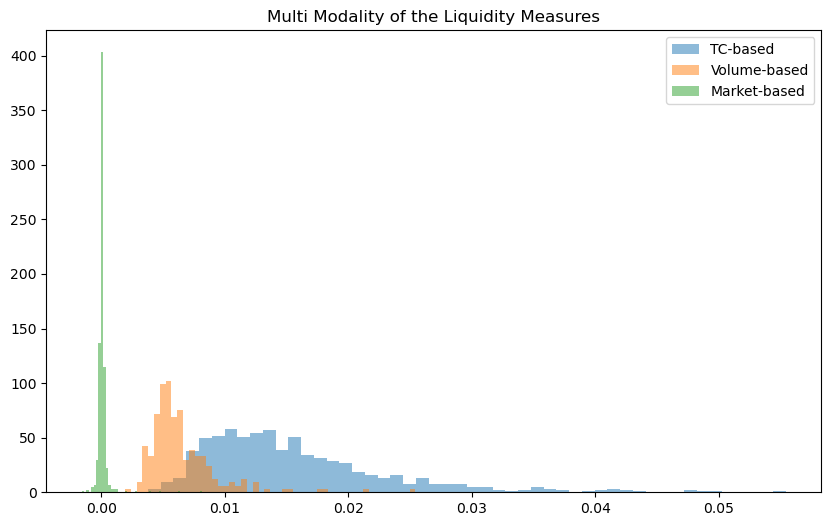

In [ ]:
# 히스토그램
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

liq_measures_all2=liq_measures_all.dropna()
# 각 column을 평균 0, 분산 1로 통일해서 비교하기 쉽게(데이터의 단위 맞추기)
scaled_liq=StandardScaler().fit_transform(liq_measures_all2)
# 설정 꾸러미
kwargs=dict(alpha=0.5, bins=50, stacked=True)
plt.hist(liq_measures_all.loc[:,'percent_quoted_ba'],**kwargs, label='TC-based')
plt.hist(liq_measures_all.loc[:,'turnover_ratio'],**kwargs, label='Volume-based')
plt.hist(liq_measures_all.loc[:,'market_impact'],**kwargs, label='Market-based')
plt.title('Multi Modality of the Liquidity Measures')
plt.legend()
plt.show()

Exception in thread Thread-765 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\82103\anaconda3\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\82103\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\82103\anaconda3\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\82103\anaconda3\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "<frozen codecs>", line 325, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


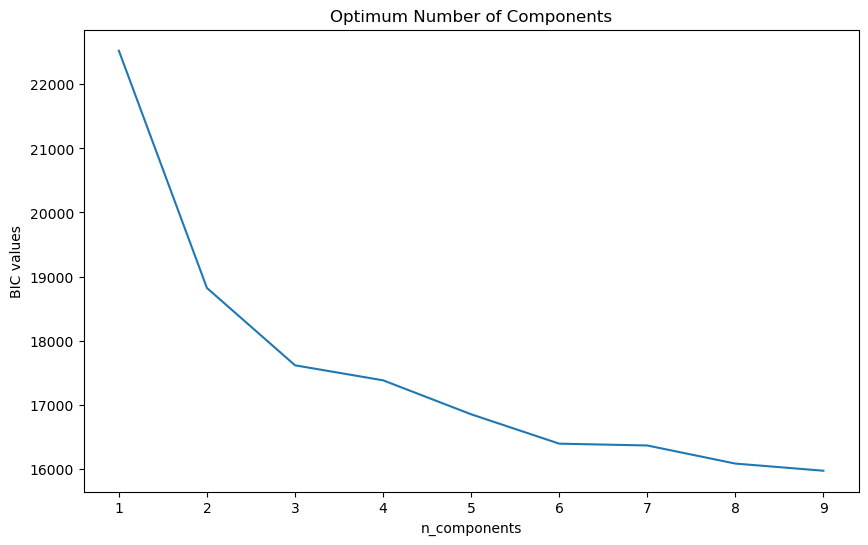

In [49]:
n_components=np.arange(1,10)
# 다른 클러스터 수를 기반으로 다른 BIC 값 생성
clusters=[GaussianMixture(n,covariance_type='spherical',random_state=0).fit(scaled_liq) for n in n_components]
plt.plot(n_components, [m.bic(scaled_liq) for m in clusters])
plt.title('Optimum Number of Components')
plt.xlabel('n_components')
plt.ylabel('BIC values')
plt.show()

- 세 번째 군집 이후에 평평해져 이상적인 중단 지점이 됨

In [ ]:
# 시장의 유동성 데이터를 입력받아 "지금 시장이 평상시인지 특이한 국면인지 등을 확률적으로 계산해줌"
def cluster_state(data, nstates):
    gmm=GaussianMixture(n_components=nstates, # 군집 개수
                        covariance_type='spherical', # 분산만 고려
                        init_params='kmeans') # gmm 구성
    gmm_fit=gmm.fit(data) # 학습
    labels=gmm_fit.predict(data) # 분류
    state_probs=gmm.predict_proba(data) # 각 데이터가 특정 군집(상태)일 확률
    state_probs_df=pd.DataFrame(state_probs, columns=['state-1','state-2','state-3'])
    state_prob_means=[state_probs_df.iloc[:,i].mean() for i in range(len(state_probs_df.columns))]
    if np.max(state_prob_means)==state_prob_means[0]:
        print('State-1 is likely to occur with a probability of {:.4f}'.format(state_prob_means[0]))
    elif np.max(state_prob_means)==state_prob_means[1]:
        print('State-2 is likely to occur with a probability of {:.4f}'.format(state_prob_means[1]))
    else:
        print('State-3 is likely to occur with a probability of {:.4f}'.format(state_prob_means[2]))
    return state_probs


In [52]:
state_probs=cluster_state(scaled_liq, 3)
print(f'State probabilities are {state_probs.mean(axis=0)}')

State-3 is likely to occur with a probability of 0.7194
State probabilities are [0.2644599  0.01612903 0.71941107]


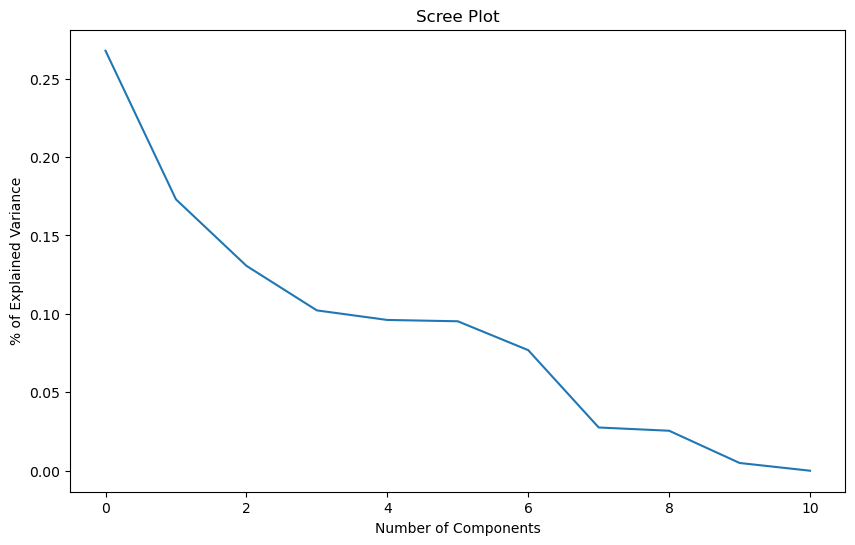

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=11) # 데이터를 설명하는 '새로운 축'을 11개 찾음
# 주성분 축으로 변환
components=pca.fit_transform(scaled_liq)
# 각 주성분이 원본 데이터의 정보를 얼마나 설명하는지
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('% of Explained Variance')
plt.show()

- 구성 요소 3에서 중지

In [57]:
def gmm_pca(data, nstate):
    pca=PCA(n_components=3)
    components=pca.fit_transform(data)
    mxtd=GaussianMixture(n_components=nstate, covariance_type='spherical')
    gmm=mxtd.fit(components)
    labels=gmm.predict(components)
    state_probs=gmm.predict_proba(components)
    return state_probs, pca

In [58]:
state_probs, pca=gmm_pca(scaled_liq, 3)
print(f'State probabilities are {state_probs.mean(axis=0)}')

State probabilities are [0.72669152 0.25717945 0.01612902]


- 상태 1로 판명!

In [59]:
def wpc():
    state_probs_df=pd.DataFrame(state_probs, columns=['state-1','state-2','state-3'])
    state_prob_means=[state_probs_df.iloc[:,i].mean() for i in range(len(state_probs_df.columns))]
    if np.max(state_prob_means)==state_prob_means[0]:
        print('State-1 is likely to occur with a probability of {:.4f}'.format(state_prob_means[0]))
    elif np.max(state_prob_means)==state_prob_means[1]:
        print('State-2 is likely to occur with a probability of {:.4f}'.format(state_prob_means[1]))
    else:
        print('State-3 is likely to occur with a probability of {:.4f}'.format(state_prob_means[2]))
wpc()

State-1 is likely to occur with a probability of 0.7267


In [ ]:
# 각 고유벡터(Eigenvectors)~주성분들이 원래 데이터의 변수들과 어떤 관계를 맺고 있는지 보여주는 가중치(Loading) 행렬
pca.components_

array([[ 0.07023491, -0.1275387 ,  0.36600492,  0.43529793,  0.39069714,
        -0.04143938,  0.00498675,  0.51722186,  0.43107958, -0.        ,
         0.21822616],
       [-0.08596895,  0.675304  , -0.00962253,  0.09688943,  0.10609874,
         0.6745362 , -0.22559179, -0.00916067,  0.07156049, -0.        ,
         0.06885625],
       [ 0.1573587 ,  0.09484465, -0.02966998, -0.48436546, -0.46370254,
         0.05758088,  0.0571029 ,  0.43396614,  0.52667987,  0.        ,
        -0.20841757]])

In [61]:
# 적재(loading) 분석: 어떤 유동성 측정이 가장 중요한지 찾기
loadings=pca.components_.T*np.sqrt(pca.explained_variance_)
loading_matrix=pd.DataFrame(loadings, columns=['PC1','PC2','PC3'], index=liq_measures_all.columns)

In [62]:
loading_matrix

,PC1,PC2,PC3
liq_ratio,0.115014,-0.113159,0.179987
Lhh,-0.208852,0.888891,0.108484
turnover_ratio,0.599355,-0.012666,-0.033937
percent_quoted_ba,0.712827,0.127534,-0.554018
percent_effective_ba,0.639790,0.139656,-0.530384
roll,-0.067860,0.887881,0.065861
CS_spread,0.008166,-0.296943,0.065314
amihud,0.846982,-0.012058,0.496372
florackis,0.705919,0.094194,0.602418
cet,-0.000000,-0.000000,0.000000


(\*) 가우스 혼합 코풀라 모델
- 각 금융기관: 신용, 유동성, 시장 및 운영 위험에 대한 자체 모델 개발
- 가장 큰 문제: 위험의 상관관계(공동 분배)
- 극단적 시장 단계에서는 위험을 포착할 수 있는 능력이 없음 ~ 위험의 상호작용을 무시하면 안됨
- 코풀라(Copula): 개별 위험의 한계 분포를 다변량 분포에 매핑해 많은 표준 균일 랜덤 변수의 공동 분포를 생성하는 함수 ~ 변수 간 상관 구조 정의가 중요
- 변수:
$\\ X = (X_1, X_2, ..., X_d)$: d개의 리스크 요인
$\\ F_i(x_i) = P(X_i \le x_i)$: 각 리스크 요인의 한계 누적 분포 함수(현실의 데이터 분포) 
- 스크라의 정리:
$\\ F(x_1, ..., x_d) = C(F_1(x_1), F_2(x_2), ..., F_d(x_d))$: 모든 다변량 경합 분포는 이렇게 표현됨
$\\ F_i(x_i): [0,1] 사이의 값을 가지는 표준 균일 분포를 따름
- 코풀라: $[0,1]^d$ 공간에서 정의된 결합 분포 함수


- 가우스 혼합 분포의 확률 밀도 함수(PDF) 도입하기
- d 차원(리스크 요인) 벡터 Y가 K개의 성분(상태)을 가진 가우스 혼합 분포
$\\ f_{GM}(y; \Theta) = \sum_{k=1}^{K} w_k \cdot \phi_d(y; \mu_k, \Sigma_k)$

1. 가우스 혼합 분포 자체의 i번째 변수에 대한 한계 CDF
$\Psi_i(y_i) = \sum_{k=1}^{K} w_k \cdot \Phi_1(y_i; \mu_{k,i}, \sigma_{k,i}^2)$
2. 입력값(현실 세계 확률값)
$C_{GM}(u_1, ..., u_d) = \Psi(\Psi_1^{-1}(u_1), \Psi_2^{-1}(u_2), ..., \Psi_d^{-1}(u_d))$
3. 결합 분포함수 미분 -> 결합 밀도 함수 ~ 코풀라 밀도
$\\ f_{GM}(y_1, ..., y_d) = c(u_1, ..., u_d) \times \prod_{i=1}^{d} \psi_i(y_i)$
$\\ \therefore c(u_1, ..., u_d) = \frac{f_{GM}(y_1, ..., y_d)}{\prod_{i=1}^{d} \psi_i(y_i)}$

In [ ]:
'''
from copulae.mixtures.gmc.gmc import GaussianMixtureCopula
_, dim=scaled_liq.shape # 리스크 요인 개수
gmcm=GaussianMixtureCopula(n_clusters=3, ndim=dim) # 상태 3개

gmcm_fit=gmcm.fit(scaled_liq, method='kmeans', criteria='GMCM', eps=0.0001) #클러스터와 차원 수로 GMCM 구성
state_prob=gmcm_fit.params.prob
print(f'The state {np.argmax(state_prob)+1} is likely to occur')
print(f'State Probabilities based on GMCM are {state_prob}')
'''
